In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import sem
from scipy.stats import linregress
import gmaps
import os
import scipy.stats as stats
from api_keys import g_key

In [2]:
#load files
file_sars_clean_2003_data= "sars_clean_country_2003 complete_data.xlsx"
file_median_ages_over_years = "Median ages over the years by countries.xls"
file_corona_clean_data = "covid_19_clean_complete_03212020.xlsx"
file_world_population = "world_population.xlsx"
file_median_age_2018 = "median age by countries 2018.xlsx"

#create DataFrame from files
df_sars_2003 = pd.read_excel(file_sars_clean_2003_data)
df_median_ages_over_years = pd.read_excel(file_median_ages_over_years)
df_corona_data =pd.read_excel(file_corona_clean_data)
df_world_population = pd.read_excel(file_world_population)
df_median_age_2018= pd.read_excel(file_median_age_2018)

In [3]:
#create column for age group
df_median_age_2018["age group"]=""
#create bin and group names for the age group column
bins=[10,19.9,29.9,39.9,50]
group_names =["10-19.9","20-29.9","30-39.9","40-49.9"]
df_median_age_2018["age group"]=pd.cut(df_median_age_2018["Median Age"],bins,labels = group_names)

In [4]:
#create column for Population
df_world_population["population"]=df_world_population["pop2020"]*1000

#merge corona data and world aged population >65 percentage
merge_population = df_corona_data.merge(df_world_population,left_on="Country",right_on="name",how="left")

#create columns for Death rate and confirmed rate
merge_population["Death Rate"]= 100*(merge_population["Sum of Deaths"]/merge_population["Sum of Confirmed"]).round(6)
merge_population["confirmed rate"] =100*(merge_population["Sum of Confirmed"]/merge_population["population"]).round(6)


In [5]:
#clean columns, merge files to include populations, median ages of various countries
merge_population= merge_population[["Country","Lat","Long","Sum of Confirmed","Sum of Deaths","Sum of Recovered",
                        "population","Death Rate","confirmed rate"]]
merge_aged = merge_population.merge(df_median_ages_over_years,left_on="Country", right_on="Country Name", how="left" )

merge_median_age_2018 = merge_aged.merge(df_median_age_2018,left_on="Country", right_on="Country Name",how="left")


In [6]:
#Clean columns again
merge_median_age_2018= merge_median_age_2018[["Country","Lat","Long","Sum of Confirmed","Sum of Deaths","Sum of Recovered","population",
                               "Death Rate","confirmed rate","2018","Median Age","age group"]]

#drop NA values 
merge_median_age_2018= merge_median_age_2018.dropna(subset=["2018","confirmed rate","age group"])

#change column names
merge_median_age_2018 =merge_median_age_2018.rename(columns = {"2018":"2018:Population ages 65 and above (% of total population)"})

In [7]:
gmaps.configure(api_key=g_key)
locations=merge_median_age_2018[["Lat","Long"]].astype(float)
aged_percentage =merge_median_age_2018["Median Age"].astype(float)
fig=gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=aged_percentage, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 2)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [8]:
#develops x-axis and y-axis for variances
confirmed_cases= merge_median_age_2018["Sum of Confirmed"]
confirmed_rate = merge_median_age_2018["confirmed rate"]
ages_percentage = merge_median_age_2018["2018:Population ages 65 and above (% of total population)"]
death_cases = merge_median_age_2018["Sum of Deaths"]
death_rate= merge_median_age_2018["Death Rate"]
age_group =merge_median_age_2018["age group"]
median_age_high = merge_median_age_2018["Median Age"]

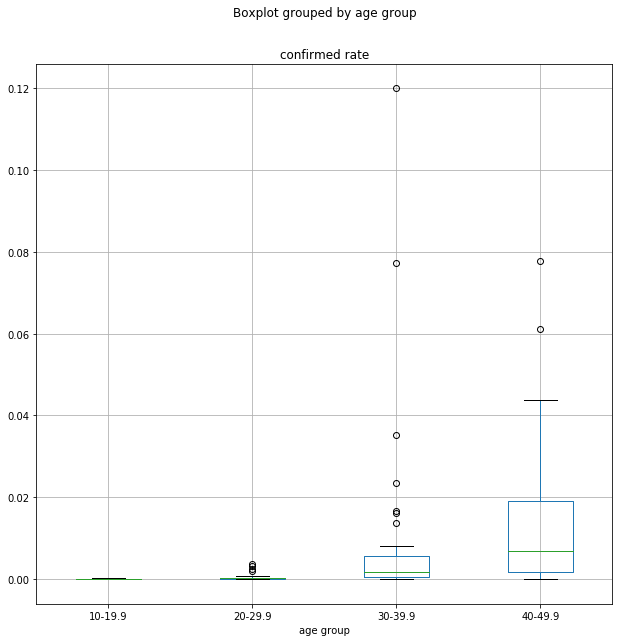

In [9]:
#develop boxplot for confirmed rate and age group
merge_median_age_2018.boxplot("confirmed rate", by= "age group",figsize=(10,10))

In [10]:
#create series for different age groups
group1 = merge_median_age_2018[merge_median_age_2018["age group"]=="10-19.9"]["confirmed rate"]
group2 = merge_median_age_2018[merge_median_age_2018["age group"]=="20-29.9"]["confirmed rate"]
group3 = merge_median_age_2018[merge_median_age_2018["age group"]=="30-39.9"]["confirmed rate"]
group4 = merge_median_age_2018[merge_median_age_2018["age group"]=="40-49.9"]["confirmed rate"]

#get p-value for different age groups
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=6.219049619572478, pvalue=0.000547305845934365)

In [11]:
#calcate median
Mean_age= merge_median_age_2018["Median Age"].mean()
median_age = merge_median_age_2018["Median Age"].median()
std = merge_median_age_2018["Median Age"].std()
print(Mean_age)
print(median_age)
print(std)

31.913669064748195
31.7
8.921990431064534


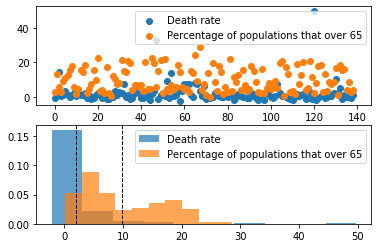

In [12]:
#pick variance - death rate and age_percentage >65
population_death_rate = stats.norm.rvs(loc=death_rate)
population2 = stats.norm.rvs(loc=ages_percentage)

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(population_death_rate)), population_death_rate, label="Death rate")
plt.scatter(range(len(population2)), population2, label="Percentage of populations that over 65")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(population_death_rate, 10, density=True, alpha=0.7, label="Death rate")
plt.hist(population2, 10, density=True, alpha=0.7, label="Percentage of populations that over 65")
plt.axvline(population_death_rate.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()  


In [13]:
##get p-value for death rate and age_percentage >65
stats.ttest_ind(population_death_rate, population2, equal_var=False)

Ttest_indResult(statistic=-10.538944734191714, pvalue=5.971962242575771e-22)

In [62]:
#filter top affected countries
top_death_rate_countries = merge_median_age_2018.loc[merge_median_age_2018["Sum of Confirmed"]>=1000]

top_death_rate_countries = top_death_rate_countries.sort_values("Sum of Confirmed",ascending = False).head(10)


In [63]:
#filter columns for top 10 affected countries
top_death_rate_countries_clean = top_death_rate_countries[["Country","Sum of Confirmed","Sum of Deaths","Death Rate",
                                                           "Median Age","age group",
                                                           "2018:Population ages 65 and above (% of total population)"]]
top_death_rate_countries_clean["Death Rate"] = top_death_rate_countries_clean["Death Rate"].round(2)
top_death_rate_countries_clean

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Country,Sum of Confirmed,Sum of Deaths,Death Rate,Median Age,age group,2018:Population ages 65 and above (% of total population)
32,China,81250,3253,4.00,38.4,30-39.9,10.920884
76,Italy,47021,4032,8.57,46.5,40-49.9,22.751680
139,Spain,20410,1043,5.11,43.9,40-49.9,19.378508
59,Germany,19848,67,0.34,47.8,40-49.9,21.461962
72,Iran,19644,1433,7.29,31.7,30-39.9,6.184574
156,United States,19100,244,1.28,38.5,30-39.9,15.807654
55,France,12726,450,3.54,41.7,40-49.9,20.034625
82,South Korea,8652,94,1.09,43.2,40-49.9,14.418556
144,Switzerland,5294,54,1.02,42.7,40-49.9,18.623217
154,United Kingdom,4014,178,4.43,40.6,40-49.9,18.395866


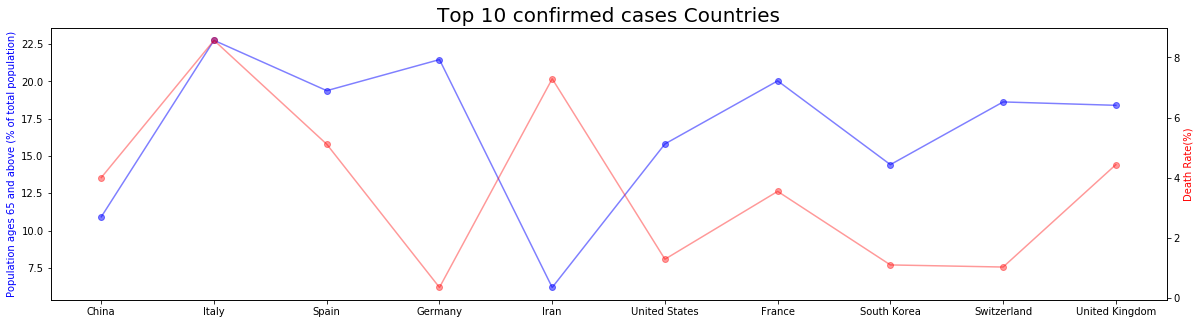

In [64]:
#Top 10 most affected countries death rate vs age>65 
#set up secondary y axis
Fig = plt.figure(figsize=(20,5))
ax= Fig.gca()

#x-axis and 2 y-axises
x_axis = top_death_rate_countries_clean["Country"]
y1_axis = top_death_rate_countries_clean["2018:Population ages 65 and above (% of total population)"]
y2_axis = top_death_rate_countries_clean["Death Rate"]

#first line
ax.plot(x_axis,y1_axis,color='b',alpha = 0.5,marker="o")

ax.set_ylabel("Population ages 65 and above (% of total population)", color ="b")

#secondary y-axis
ax2 = ax.twinx()

ax2.plot(x_axis,y2_axis,color='r',alpha = 0.4,marker="o")
ax2.set_ylabel("Death Rate(%)", color ="r")

plt.title("Top 10 confirmed cases Countries",fontsize = 20)

#present fig
plt.show()